# TP EPITA - KANTAR

Authors : Matis Braun / Virgile Hermant / Lylian Cazale / Juliette Jacquot

## Introduction

Voici le résultat de nos recherches pour le projet donné par Kantar. On nous a fourni un jeu de données contenant 5000 individus et leurs informations, leurs opinions/positions et leurs activité/consommation vis à vis de leurs espaces extérieurs.

L'étude "Jardins et terrasses" datant de Février 2020 avait comme thème principal: "Comment les Français profitent-ils de leur jardin ou terrasse ?"

Nous allons effectuer 3 étapes en utilisant leurs datas :

- Une clusterisation des individus en fonction de leurs données
- Leur réaffectation dans des groupes en utilisant des variables actives
- Leur réaffectation dans des groupes en utilisant des variables illustratives

Le but final serait de pouvoir analyser cela pour leur proposer des offres en fonction de leur affectation à un groupe (grâce à nos 3 étapes)

Le premier fichier csv `fic_epita_kantar_labels.csv` contient les labels (donc les réponses telles qu'elles ont été données (ex: Jamais, Plus rarement, Yes, No,...).

Le deuxième fichier csv `fic_epita_kantar_codes.csv` représente les mêmes réponses des utilisateurs mais cette fois-ci converties en valeur mathématique (ex: Yes devient 1, No devient 0,...)

In [65]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [4]:
df = pd.read_csv("EPITA_KANTAR_TP1/fic_epita_kantar_codes.csv", sep=";")
df.head()

,cle,Respondent_ID,weight,A11,A12,A13,A14,A4,A5,A5bis,...,RS193,RS102RECAP,rs11recap2,RS11recap,RS193bis,RS2Recap,RS56Recap,RS2,RS11,RS102
0,1,MET20_999999996,2.501255,1,0,0,0,1,2.0,NaN,...,2,4,1,2,NaN,1,1,24,0,4
1,2,MET20_98888888,0.722914,1,0,0,0,1,5.0,NaN,...,2,1,1,2,NaN,4,1,50,0,1
2,3,MET20_1978307,1.039611,1,0,0,0,1,2.0,NaN,...,2,3,2,1,NaN,3,2,37,1,3
3,4,MET20_1302078,0.976590,1,1,1,0,1,1.0,NaN,...,2,2,1,2,NaN,5,3,63,0,2
4,5,MET20_1869308,0.812315,0,1,0,0,2,NaN,1.0,...,2,3,2,1,NaN,3,1,44,1,3


### 1-1 Données sur l'opinion/position du consommateur (Orange)

In [5]:
"""
On recupere nos données
"""
A9 = df.loc[:, ["A9_1_slice", "A9_2_slice", "A9_3_slice", "A9_4_slice", "A9_5_slice", "A9_6_slice", "A9_7_slice", "A9_8_slice", "A9_9_slice", "A9_10_slice", "A9_11_slice", "A9_12_slice", "A9_13_slice", "A9_14_slice", "A9_15_slice", "A9_16_slice"]]
A10 = df.loc[:, ["A10_1_slice", "A10_2_slice", "A10_3_slice", "A10_4_slice", "A10_5_slice", "A10_6_slice", "A10_7_slice", "A10_8_slice"]]
A11 = df.loc[:, ["A11_1_slice", "A11_2_slice", "A11_3_slice", "A11_4_slice", "A11_5_slice", "A11_6_slice", "A11_7_slice", "A11_8_slice", "A11_9_slice", "A11_10_slice", "A11_11_slice", "A11_12_slice", "A11_13_slice"]]
Weights = df.loc[:, ["weight"]]

"""
On inverse les valeurs pour les questions "négatives"
"""
A9["A9_5_slie"] = A9["A9_5_slice"].map({1: 4, 2: 3, 3: 2, 4: 1})
A10["A10_6_slice"] = A10["A10_6_slice"].map({1: 4, 2: 3, 3: 2, 4: 1})

In [6]:
"""
On fait le PCA pour réduire les dimensions pour A9, A10, A11
"""
scaler = StandardScaler()
A9_normalized = scaler.fit_transform(A9)
A10_normalized = scaler.fit_transform(A10)
A11_normalized = scaler.fit_transform(A11)

A9_pca = PCA(n_components=1)
A10_pca = PCA(n_components=1)
A11_pca = PCA(n_components=1)

A9_pca_result = A9_pca.fit_transform(A9_normalized)
A10_pca_result = A10_pca.fit_transform(A10_normalized)
A11_pca_result = A11_pca.fit_transform(A11_normalized)

A9_pca_df = pd.DataFrame(A9_pca_result, columns=["PCA1_value"])
A10_pca_df = pd.DataFrame(A10_pca_result, columns=["PCA2_value"])
A11_pca_df = pd.DataFrame(A11_pca_result, columns=["PCA3_value"])

In [7]:
data_cluster = pd.concat([A9_pca_df, A10_pca_df, A11_pca_df], axis=1)

#### K-Means

In [8]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(data_cluster)
data_cluster['KMeans_Label'] = kmeans_labels

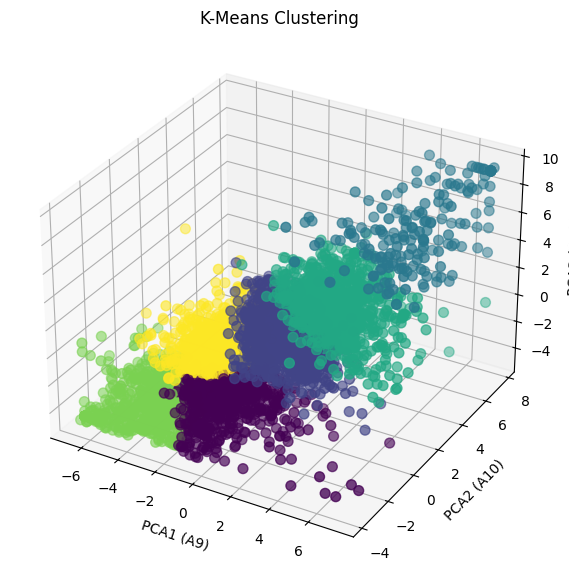

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_cluster.iloc[:, 0], data_cluster.iloc[:, 1], data_cluster.iloc[:, 2],
           c=data_cluster['KMeans_Label'], cmap='viridis', s=50)
ax.set_title("K-Means Clustering")
ax.set_xlabel("PCA1 (A9)")
ax.set_ylabel("PCA2 (A10)")
ax.set_zlabel("PCA3 (A11)")
plt.show()

On constate 6 clusters dans notre graphe.

- Le vert clair qui contient les utilisateurs plutôt "très positif". Comme on l'a pu le constater sur les dataframes, l'utilisateur 1 a répondu tout le temps `Tout à fait d'accord` , et lorsqu'on regarde son score PCA, il est à -6 environ. On constate donc que le cluster vert clair contient les gens à réponses "très positive".
- A l'inverse, le vert foncé à droite contient les utilisateurs à réponses "négative", car leurs valeurs se trouvent à l'extrême positif.
- Quant au violet, il doit sûrement contenir les personnes entre "neutre" et "positif"
- Le vert foncé contient les personnes entre "neutre" et "négatif"
- Le bleu foncé et le jaune contiennent les personnes "neutres"

Nous avons pu répartir les consommateurs dans 6 groupes différents en fonction de leur opinion/position vis-à-vis des espaces extérieurs / jardins.

### 1-1 Données sur l'activité/consommation des consommateurs (Vert)

In [10]:
"""
On recupere nos données
"""
A = df.loc[:, ["A11", "A12", "A13", "A14", "A4", "A5", "A5bis", "A8_1_slice", "A8_2_slice", "A8_3_slice", "A8_4_slice"]]
B = df.loc[:, ["B1_1_slice", "B1_2_slice", "B2_1_slice", "B2_2_slice", "B3", "B4", "B6"]]
C = df.loc[:, ["C1_1_slice", "C1_2_slice", "C1_3_slice", "C1_4_slice", "C1_5_slice", "C1_6_slice", "C1_7_slice", "C1_8_slice", "C1_9_slice"]]
Weights = df.loc[:, ["weight"]]

A["A5"] = A["A5"].combine_first(df["A5bis"])
A = A.drop("A5bis", axis=1)
print(A.head(10))


   A11  A12  A13  A14  A4   A5  A8_1_slice  A8_2_slice  A8_3_slice  A8_4_slice
0    1    0    0    0   1  2.0           2           2           2           2
1    1    0    0    0   1  5.0           2           0           0           0
2    1    0    0    0   1  2.0           5           5           1           1
3    1    1    1    0   1  1.0           2           3           2           1
4    0    1    0    0   2  1.0           1           1           1           1
5    1    0    0    0   1  2.0           0           1           0           0
6    1    0    0    0   1  1.0           4           2           0           0
7    1    0    1    0   1  2.0           8           4          10          10
8    1    0    1    0   3  4.0           1           1           1           0
9    1    0    0    0   1  2.0           3           3           1           1


In [11]:
"""
On fait le PCA pour réduire les dimensions pour A9, A10, A11
"""
scaler = StandardScaler()
A_normalized = scaler.fit_transform(A)
B_normalized = scaler.fit_transform(B)
C_normalized = scaler.fit_transform(C)

A_pca = PCA(n_components=1)
B_pca = PCA(n_components=1)
C_pca = PCA(n_components=1)

A_pca_result = A_pca.fit_transform(A_normalized)
B_pca_result = B_pca.fit_transform(B_normalized)
C_pca_result = C_pca.fit_transform(C_normalized)

A_pca_df = pd.DataFrame(A_pca_result, columns=["PCA1_value"])
B_pca_df = pd.DataFrame(B_pca_result, columns=["PCA2_value"])
C_pca_df = pd.DataFrame(C_pca_result, columns=["PCA3_value"])

A_pca_df.head(5)

,PCA1_value
0,-0.153630
1,-0.260694
2,0.014792
3,-0.788975
4,-2.161763


In [12]:
data_cluster2 = pd.concat([A_pca_df, B_pca_df, C_pca_df], axis=1)

#### K-Means

In [13]:
kmeans2 = KMeans(n_clusters=6, random_state=42)
kmeans_labels2 = kmeans2.fit_predict(data_cluster2)
data_cluster2['KMeans_Label'] = kmeans_labels2

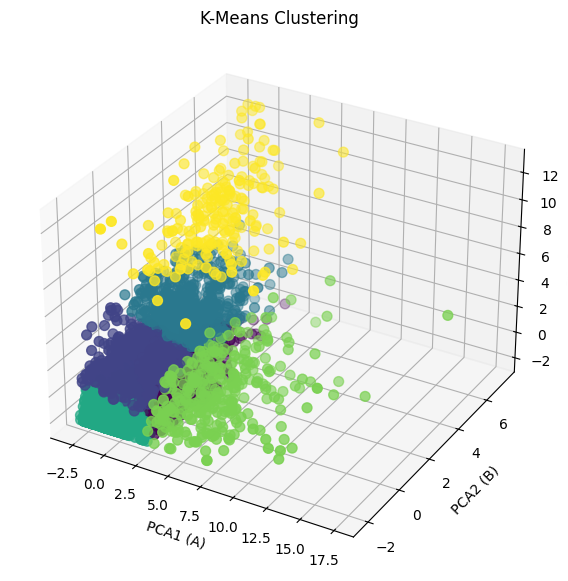

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_cluster2.iloc[:, 0], data_cluster2.iloc[:, 1], data_cluster2.iloc[:, 2],
           c=data_cluster2['KMeans_Label'], cmap='viridis', s=50)
ax.set_title("K-Means Clustering")
ax.set_xlabel("PCA1 (A)")
ax.set_ylabel("PCA2 (B)")
ax.set_zlabel("PCA3 (C)")
plt.show()

On constate 6 clusters assez regroupés dans notre graphe.

- Le vert qui contient les utilisateurs plutôt "très actif". Comme on a pu le constater sur les dataframes, lorsque l'utilisateur répond aux réponses de la variable B, la valeur `Jamais` correspond à 4 et la valeur `A chaque fois que vous jardinez ou presque` , correspond à 0.
- A l'inverse, le jaune et vert clair en haut et à droite contiennent les utilisateurs à réponses "peu actif", car leurs valeurs se trouvent à l'extrême positif.
- Quant au vert foncé, bleu foncé (que l'on voit presque pas) et violet, ils doivent sûrement contenir les personnes "moyen actif"

# 3 - Réaffectation des individus dans les groupes avec variables illustratives

## Consignes

Pour chacune des 2 clusterisations, vous devez affecter les individus dans les groupes en utilisant des variables illustratives.
- Pour la segmentation variables en Orange
- - Affectation avec les variables en Vert
- - Affectation avec les variables suivantes rs3 rs5 rs6 RS1 RS191 RS192 RS193
RS102RECAP rs11recap2 RS11recap RS193bis RS2Recap RS56Recap RS2 RS11
RS102
- Pour la segmentation variables en Vert
- - Affectation avec les variables en Orange
- - Affectation avec les variables suivantes rs3 rs5 rs6 RS1 RS191 RS192 RS193
RS102RECAP rs11recap2 RS11recap RS193bis RS2Recap RS56Recap RS2 RS11 RS102


L’objectif est de déterminer des algorithmes qui pourront être utilisés sur un fichier annexe ou fichier client dans lequel nous ne disposons que des variables sélectionnées. Déterminer la capacité d’affectation les individus avec ces variables illustratives.


Pour faire une réaffectation des individus dans les groupes à partir de variables illustratives, l'objectif est de construire pour les 2 segmentations (Orange et Vert), un modèle de prédiction du cluster en se basant uniquement sur les variables disponibles dans le fichier annexe/client.

Grâce à cela, lorsque l'on aura un consommateur avec comme informations que ces variables illutratives, nous pourrons lui attribuer un cluster auquel il a le plus de probabilité d'appartenir.

Donc nous avons fait 2 segmentations (Orange et Vert) avec pour chaque un jeu de données, et on connait l'appartenance de chaque consommateur à leurs clusters.

Nous allons donc :

- Prendre que les variables illustratives (Vert, Orange, RS) et vérifier si on peut réattribuer les individus à leur cluster initial.
- Évaluer leur réaffectation

Pour les 2 segmentations, nous allons utiliser ces modèles de classification :

- Analyse Discriminante
- Random Forest
- XGBoost
- Régression logistique multinomiale

Pour l'évaluation nous allons faire :

- Une classification report
- Matrice de confusion

Vu que nous avons déjà le Dataframe `data_cluster` (Orange) et `data_cluster2` (Vert), il nous faut maintenant le Dataframes pour les variables RS.

In [15]:
RS = df.loc[:, ["rs3", "rs5", "rs6", "RS1", "RS191", "RS192", "RS193", "RS102RECAP", "rs11recap2", "RS11recap", "RS193bis", "RS2Recap", "RS56Recap", "RS2", "RS11", "RS102"]]
RS.head(5)

,rs3,rs5,rs6,RS1,RS191,RS192,RS193,RS102RECAP,rs11recap2,RS11recap,RS193bis,RS2Recap,RS56Recap,RS2,RS11,RS102
0,1,1,5.0,1,1.0,2,2,4,1,2,NaN,1,1,24,0,4
1,1,1,2.0,1,1.0,2,2,1,1,2,NaN,4,1,50,0,1
2,1,1,9.0,2,1.0,1,2,3,2,1,NaN,3,2,37,1,3
3,2,3,NaN,2,1.0,2,2,2,1,2,NaN,5,3,63,0,2
4,1,1,6.0,1,2.0,2,2,3,2,1,NaN,3,1,44,1,3


In [16]:
"""
On voit que l'on a des NaN, remplacons les par des 0
"""
RS["rs6"] = RS["rs6"].fillna(0)
RS["RS193bis"] = RS["RS193bis"].fillna(0)
RS["RS191"] = RS["RS191"].fillna(0)

In [17]:
"""
On fait le PCA pour réduire les dimensions pour A9, A10, A11
"""
scaler = StandardScaler()
RS_normalized = scaler.fit_transform(RS)
RS_pca = PCA(n_components=3)
RS_pca_result = RS_pca.fit_transform(RS_normalized)
RS_pca_df = pd.DataFrame(RS_pca_result, columns=["PCA1_value", "PCA2_value", "PCA3_value"])
RS_pca_df.head(5)

,PCA1_value,PCA2_value,PCA3_value
0,2.297442,-1.052755,0.419549
1,-0.875542,-1.450735,0.377575
2,2.603890,-0.777683,0.119450
3,-1.736525,0.174573,-1.214904
4,2.289727,-0.466359,0.360372


### Segmentation des variables en Orange

Maintenant que nous avons les 3 PCA pour les variables Vert et les variables RS, regardons les résultats des différents modèles de classifications en fonction des variables que l'on utilise.

In [113]:
"""
On récupère nos données et on les splits pour le Train et Test
"""
"""
Variables "Vert"
"""
X = data_cluster2[["PCA1_value", "PCA2_value", "PCA3_value"]]
y = data_cluster["KMeans_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""
Variable RS
"""
X2 = RS_pca_df[["PCA1_value", "PCA2_value", "PCA3_value"]]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

"""
Variables "Orange"
"""
X3 = data_cluster[["PCA1_value", "PCA2_value", "PCA3_value"]]
y2 = data_cluster2["KMeans_Label"]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y2, test_size=0.2, random_state=42)

"""
Variable RS 2
"""
X4 = RS_pca_df[["PCA1_value", "PCA2_value", "PCA3_value"]]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y2, test_size=0.2, random_state=42)

Nous prendrons dans un premier temps les variables "Vert" (qui caractérisent les informations sur l'activité / consommations des individus dans les espaces extérieurs / jardins)
Nous prendrons dans un second temps les variables "RS" (qui caractérisent les informations personnelles des individus)

#### Analyse Discriminante avec variables "Vert"

Nous allons donc maintenant utiliser les variables qui caractérisent l'activité/consommations des individus pour essayer de les classer dans des groupes divisé avec la métrique de leurs opinions.

L'analyse discriminante est une méthode de classification supervisée qui va chercher des combinaisons linéaires de nos variables pour les séparer en groupes. Pour chaque nouvel individu, on va évaluer son score d'appartenance grâce aux combinaisons linéaires de chaque groupe et va lui assigner celui qui maximise ce score.

In [48]:
"""
On entraine le modèle Analyse Discriminante
"""
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

"""
On prédit avec les données de test
"""
y_pred = lda.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.39      0.81      0.53       291
           2       0.00      0.00      0.00        43
           3       0.46      0.19      0.27       148
           4       0.43      0.40      0.42       115
           5       0.43      0.38      0.41       260

    accuracy                           0.41      1000
   macro avg       0.29      0.30      0.27      1000
weighted avg       0.34      0.41      0.35      1000



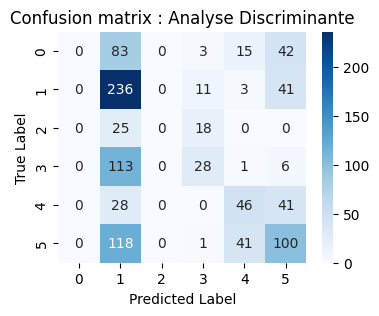

In [56]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test, y_pred))

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, title="Confusion matrix : Analyse Discriminante")

On constate une très mauvaise répartition des prédictions. Notre modèle ne prédit majoritairement que sur les clusters 1, 3, 4 et 5, surtout énormément le cluster 1 comme on le voit sur la matrice de confusion. Il ne prédit carrément jamais sur le cluster 0 et 2. Il n'arrive pas a généraliser. Voyont les autres modèles.

#### Random Forest avec variables "Vert"

Random Forest Classifier va construire un grand nombre d'arbes de décision, puis les prédictions de tous ces arbres seront ensuite agrégées pour améliorer la robustesse et la précision.

In [57]:
"""
On entraine le modèle Random Forest Classifier
"""
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

"""
On prédit avec les données de test
"""
y_pred_rf = rf.predict(X_test)

Classification report :
               precision    recall  f1-score   support

           0       0.29      0.18      0.22       143
           1       0.40      0.48      0.44       291
           2       0.29      0.19      0.23        43
           3       0.31      0.32      0.31       148
           4       0.35      0.41      0.38       115
           5       0.36      0.35      0.35       260

    accuracy                           0.36      1000
   macro avg       0.33      0.32      0.32      1000
weighted avg       0.35      0.36      0.35      1000



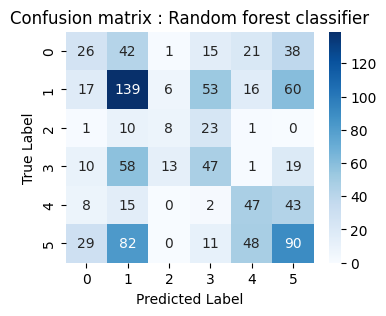

In [58]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, title="Confusion matrix : Random forest classifier")

Ici, on constate que la Random Forest Classifier arrive à bien mieux généraliser les prédictions, même si elle a de moins bon résultats. Vu que notre accuracy est améliorable en changeant les hyper paramètres, regardons les résultats des autres modèles avant de le faire.

#### XGBoost avec variables "Vert"

XGBoost est normalement le modèle le plus performant et optimisé ici. Il construit un ensemble d'arbres de décisions en corrigieant les erreurs à chaque itérations, ce qui permet d'avoir un modèle performant, rapide et efficace même sur des grand volumes de données.

In [85]:
"""
On entraine le modèle XGBoost
"""
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")
xgb.fit(X_train, y_train)

"""
On prédit avec les données de test
"""
y_pred_xgb = xgb.predict(X_test)

Classification report :
               precision    recall  f1-score   support

           0       0.23      0.13      0.17       143
           1       0.40      0.52      0.45       291
           2       0.21      0.07      0.11        43
           3       0.35      0.41      0.38       148
           4       0.39      0.42      0.40       115
           5       0.37      0.32      0.34       260

    accuracy                           0.37      1000
   macro avg       0.33      0.31      0.31      1000
weighted avg       0.35      0.37      0.35      1000



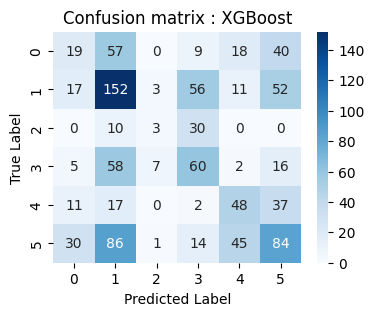

In [86]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, title="Confusion matrix : XGBoost")

Le modèle XGBoost réussi à avoir un peu de meilleurs résultats mais généralise un peu moins que le Random Forest Classifier. Vu que notre accuracy est améliorable en changeant les hyper paramètres, regardons les résultats des autres modèles avant de le faire.

#### Regression Logistique multinomiale avec variables "Vert"

La régression logistique multinomiale est une régression logistique à plusieurs classes. Elle modélise la probabilité d'appartenance à chaque classe via des fonctions logistiques en estimant les coefficients pour chaque variable.

In [61]:
"""
On entraine le modèle Logistic Regression Multinomial
"""
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

"""
On prédit avec les données de test
"""
y_pred_lr = lr.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.41      0.70      0.52       291
           2       0.00      0.00      0.00        43
           3       0.42      0.41      0.41       148
           4       0.49      0.36      0.41       115
           5       0.43      0.47      0.45       260

    accuracy                           0.42      1000
   macro avg       0.29      0.32      0.30      1000
weighted avg       0.35      0.42      0.38      1000



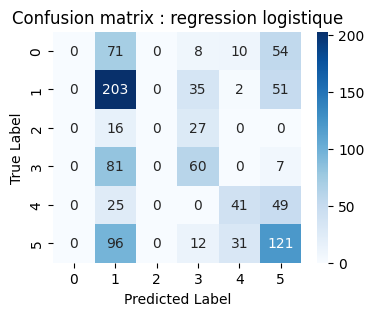

In [62]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test, y_pred_lr))
plot_confusion_matrix(y_test, y_pred_lr, title="Confusion matrix : regression logistique")

Comme pour l'analyse discriminante, on constate une très mauvaise répartition des prédictions. Notre modèle ne prédit majoritairement que sur les clusters 1, 3, 4 et 5, surtout énormément le cluster 1 comme on le voit sur la matrice de confusion. Il ne prédit carrément jamais sur le cluster 0 et 2. Il n'arrive pas a généraliser.

Après avoir vu les résultats des différents modèles, essayons de changer les paramètres de XGBoost pour essayer d'avoir de meilleurs résultats.

In [71]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='recall_macro', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
Meilleure accuracy : 0.3255759433753843


Classification report :
               precision    recall  f1-score   support

           0       0.28      0.08      0.13       143
           1       0.41      0.63      0.50       291
           2       0.29      0.05      0.08        43
           3       0.37      0.41      0.39       148
           4       0.39      0.34      0.36       115
           5       0.40      0.37      0.39       260

    accuracy                           0.39      1000
   macro avg       0.36      0.31      0.31      1000
weighted avg       0.38      0.39      0.37      1000



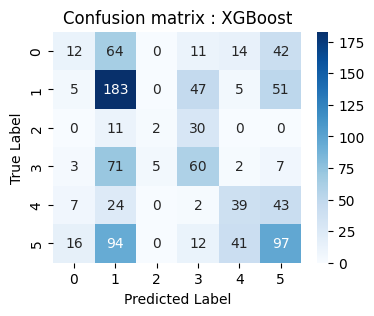

In [72]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix : XGBoost")

On constate que lorsqu'on essaye de prendre les meilleurs résultats sur le recall, notre accuracy n'est que de 0.3933. Nos modèles n'arrivent vraiment pas à généraliser, ce qui doit etre dû au nombre de données qui n'est pas très grande, et nos clusters qui étaient de base moyen (0.29 de silhouette score et un ratio de 3.7)
Essayons de voir les résultats avec la meilleure accuracy

In [79]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
Meilleure accuracy : 0.4035


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.39      0.74      0.51       291
           2       0.00      0.00      0.00        43
           3       0.43      0.35      0.39       148
           4       0.49      0.35      0.41       115
           5       0.45      0.43      0.44       260

    accuracy                           0.42      1000
   macro avg       0.29      0.31      0.29      1000
weighted avg       0.35      0.42      0.37      1000



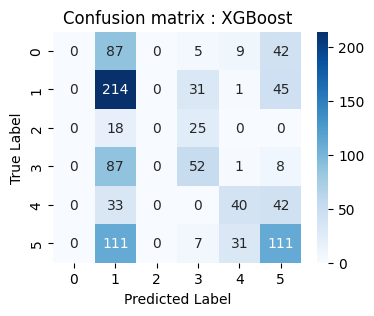

In [80]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix : XGBoost")

Notre meilleure accuracy est de 0.42.

Nous avons aussi essayé en équilibrant le poids des classes, les résultats étaient encore pire.

On peut donc conclure qu'essayer de classifier les consommateurs dans des groupes clusteriser par leurs opinions en fonction de leurs comportements ne donne pas de bons résultats. La différence entre l'opinion et leur comportement (les actions qu'ils entreprennent réellement) sont difficile à corréler. Meme si nos résultats montrent que ce sera toujours mieux d'utiliser nos modèles que de distribuer les individus aléatoirements dans les groupes.

#### Analyse Discriminante avec variables "RS"

Nous allons maintenant utiliser les variables qui caractérisent les données personelles des individus pour essayer de les classer dans des groupes divisé avec la métrique de leurs opinions.

L'analyse discriminante est une méthode de classification supervisée qui va chercher des combinaisons linéaires de nos variables pour les séparer en groupes. Pour chaque nouvel individu, on va évaluer son score d'appartenance grâce aux combinaisons linéaires de chaque groupe et va lui assigner celui qui maximise ce score.

In [73]:
"""
On entraine le modèle Analyse Discriminante
"""
lda = LinearDiscriminantAnalysis()
lda.fit(X_train2, y_train2)

"""
On prédit avec les données de test
"""
y_pred = lda.predict(X_test2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.29      1.00      0.45       291
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00       148
           4       0.00      0.00      0.00       115
           5       0.00      0.00      0.00       260

    accuracy                           0.29      1000
   macro avg       0.05      0.17      0.08      1000
weighted avg       0.08      0.29      0.13      1000



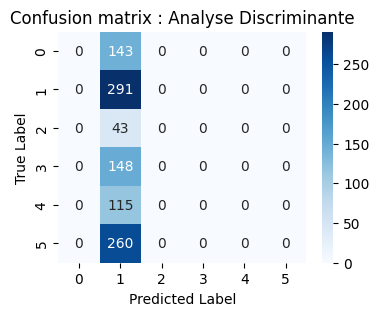

In [74]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test2, y_pred))
plot_confusion_matrix(y_test2, y_pred, title="Confusion matrix : Analyse Discriminante")

Ici, en utilisant les variables "RS", c'est encore pire. Notre modèle ne généralise absolument pas et préfère toujours prédire sur un cluster. Ce n'est absolument pas à utiliser.

#### Random Forest avec variables "RS"

Random Forest Classifier va construire un grand nombre d'arbes de décision, puis les prédictions de tous ces arbres seront ensuite agrégées pour améliorer la robustesse et la précision.

In [75]:
"""
On entraine le modèle Random Forest Classifier
"""
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train2, y_train2)

"""
On prédit avec les données de test
"""
y_pred_rf = rf.predict(X_test2)

Classification report :
               precision    recall  f1-score   support

           0       0.14      0.10      0.12       143
           1       0.30      0.34      0.32       291
           2       0.07      0.05      0.06        43
           3       0.12      0.12      0.12       148
           4       0.09      0.11      0.10       115
           5       0.23      0.21      0.22       260

    accuracy                           0.20      1000
   macro avg       0.16      0.16      0.15      1000
weighted avg       0.20      0.20      0.20      1000



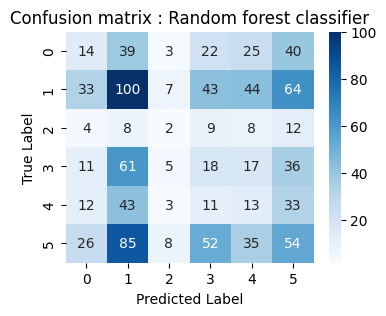

In [76]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test2, y_pred_rf))
plot_confusion_matrix(y_test2, y_pred_rf, title="Confusion matrix : Random forest classifier")

Ici, notre modèle random forest arrive un peu plus à généraliser, mais a une accuracy de 0.20. C'est limite à peine meilleur que si on prédisait les classes aléatoirement (0.16).

#### XGBoost avec variables "RS"

XGBoost est normalement le modèle le plus performant et optimisé ici. Il construit un ensemble d'arbres de décisions en corrigieant les erreurs à chaque itérations, ce qui permet d'avoir un modèle performant, rapide et efficace même sur des grand volumes de données.

In [77]:
"""
On entraine le modèle XGBoost
"""
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")
xgb.fit(X_train2, y_train2)

"""
On prédit avec les données de test
"""
y_pred_xgb = xgb.predict(X_test2)

Classification report :
               precision    recall  f1-score   support

           0       0.10      0.06      0.08       143
           1       0.27      0.35      0.30       291
           2       0.04      0.02      0.03        43
           3       0.14      0.11      0.13       148
           4       0.08      0.09      0.08       115
           5       0.24      0.23      0.23       260

    accuracy                           0.20      1000
   macro avg       0.14      0.14      0.14      1000
weighted avg       0.19      0.20      0.19      1000



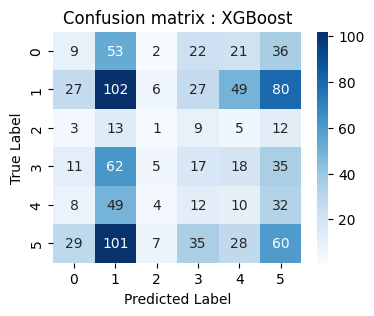

In [78]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test2, y_pred_xgb))
plot_confusion_matrix(y_test2, y_pred_xgb, title="Confusion matrix : XGBoost")

La même chose que random forest ici.

#### Regression Logistique multinomiale avec variables "RS"

La régression logistique multinomiale est une régression logistique à plusieurs classes. Elle modélise la probabilité d'appartenance à chaque classe via des fonctions logistiques en estimant les coefficients pour chaque variable.

In [87]:
"""
On entraine le modèle Logistic Regression Multinomial
"""
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train2, y_train2)

"""
On prédit avec les données de test
"""
y_pred_lr = lr.predict(X_test2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.29      1.00      0.45       291
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00       148
           4       0.00      0.00      0.00       115
           5       0.00      0.00      0.00       260

    accuracy                           0.29      1000
   macro avg       0.05      0.17      0.08      1000
weighted avg       0.08      0.29      0.13      1000



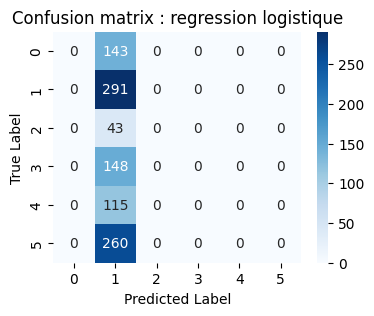

In [89]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test2, y_pred_lr))
plot_confusion_matrix(y_test2, y_pred_lr, title="Confusion matrix : regression logistique")

Ici, en utilisant les variables "RS", c'est encore pire. Notre modèle ne généralise absolument pas et préfère toujours prédire sur un cluster. Ce n'est absolument pas à utiliser.

Après avoir vu les résultats des différents modèles, essayons de changer les paramètres de XGBoost pour essayer d'avoir de meilleurs résultats.

In [90]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='recall_macro', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train2, y_train2)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test2)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Meilleure accuracy : 0.19955195101001483


Classification report :
               precision    recall  f1-score   support

           0       0.11      0.08      0.09       143
           1       0.28      0.33      0.30       291
           2       0.09      0.05      0.06        43
           3       0.14      0.14      0.14       148
           4       0.12      0.14      0.13       115
           5       0.24      0.24      0.24       260

    accuracy                           0.21      1000
   macro avg       0.16      0.16      0.16      1000
weighted avg       0.20      0.21      0.20      1000



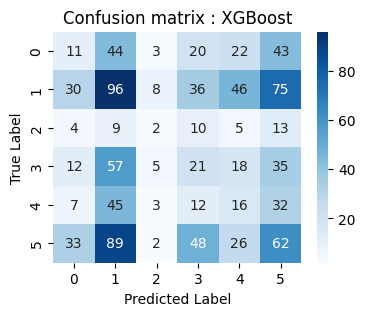

In [91]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test2, y_pred))
plot_confusion_matrix(y_test2, y_pred, title="Confusion matrix : XGBoost")

On constate que lorsqu'on essaye de prendre les meilleurs résultats sur le recall, notre accuracy n'est que de 0.21. Nos modèles n'arrivent vraiment pas à généraliser, ce qui doit etre dû au nombre de données qui n'est pas très grande, et nos clusters qui étaient de base moyen (0.29 de silhouette score et un ratio de 3.7) Essayons de voir les résultats avec la meilleure accuracy

In [92]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train2, y_train2)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test2)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Meilleure accuracy : 0.29050000000000004


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.29      1.00      0.45       291
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00       148
           4       0.00      0.00      0.00       115
           5       0.00      0.00      0.00       260

    accuracy                           0.29      1000
   macro avg       0.05      0.17      0.07      1000
weighted avg       0.08      0.29      0.13      1000



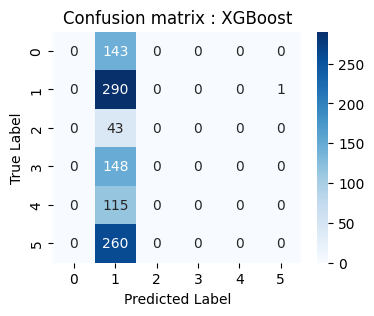

In [94]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test2, y_pred))
plot_confusion_matrix(y_test2, y_pred, title="Confusion matrix : XGBoost")

Notre meilleure accuracy est de 0.29.

Nous avons aussi essayé en équilibrant le poids des classes, les résultats étaient encore pire.

On peut donc conclure qu'essayer de classifier les consommateurs dans des groupes clusteriser par leurs opinions en fonction de leurs informations personnelles donne de pires résultats que lorsqu'on utilisait leurs données de comportement. La différence entre l'opinion et leurs informations personnelles sont presque impossible à corréler dans cette étude. Meme si nos résultats montrent que ce sera toujours mieux d'utiliser nos modèles que de distribuer les individus aléatoirements dans les groupes.

Pour conclure pour la partie "Segmentation des variables en Orange", on constate que les variables "Vert" et "RS" ne sont pas forcément corrélés avec les clusters créer avec les variables "Orange". Il peut être donc difficile de faire des études dessus, ou proposer des offres en utilisant la méthode de réaffectation des individus avec avec variables illustratives. Même si ce sera toujours mieux que de faire aléatoirement si nous n'avons pas le choix.

## Segmentation des variables en Vert

Maintenant que nous avons les 3 PCA pour les variables Orange et les variables RS, regardons les résultats des différents modèles de classifications en fonction des variables que l'on utilise.

Nous prendrons dans un premier temps les variables "Orange" (qui caractérisent les informations sur l'opinion / la position des individus sur les espaces extérieurs / jardins). Nous prendrons dans un second temps les variables "RS" (qui caractérisent les informations personnelles des individus)

#### Analyse Discriminante avec variables "Orange"

Nous allons donc maintenant utiliser les variables qui caractérisent l'opinion/position des individus pour essayer de les classer dans des groupes divisé avec la métrique de leurs activités/consommation.

L'analyse discriminante est une méthode de classification supervisée qui va chercher des combinaisons linéaires de nos variables pour les séparer en groupes. Pour chaque nouvel individu, on va évaluer son score d'appartenance grâce aux combinaisons linéaires de chaque groupe et va lui assigner celui qui maximise ce score.

In [102]:
"""
On entraine le modèle Analyse Discriminante
"""
lda = LinearDiscriminantAnalysis()
lda.fit(X_train3, y_train3)

"""
On prédit avec les données de test
"""
y_pred = lda.predict(X_test3)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.29      0.49      0.36       246
           1       0.37      0.06      0.11       158
           2       0.35      0.18      0.24       123
           3       0.60      0.78      0.68       371
           4       0.00      0.00      0.00        64
           5       0.50      0.26      0.34        38

    accuracy                           0.45      1000
   macro avg       0.35      0.30      0.29      1000
weighted avg       0.42      0.45      0.40      1000



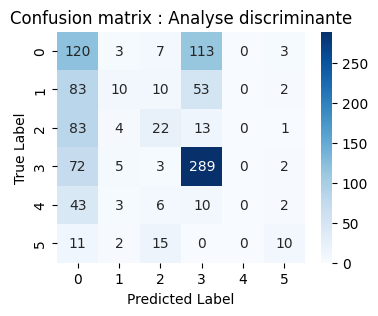

In [103]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test3, y_pred))
plot_confusion_matrix(y_test3, y_pred, title="Confusion matrix : Analyse discriminante")

On constate qu'on a de meilleurs résultats que lors de l'analyse discriminante avec variables "Vert". On peut donc se dire que c'est plus facile de faire de la réaffectation dans cette configuration. On a aussi une meilleure répartition que dans le cas avant. Il ne prédit pas du tout le cluster 4.

#### Random Forest avec variables "Orange"

Random Forest Classifier va construire un grand nombre d'arbes de décision, puis les prédictions de tous ces arbres seront ensuite agrégées pour améliorer la robustesse et la précision.

In [104]:
"""
On entraine le modèle Random Forest Classifier
"""
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train3, y_train3)

"""
On prédit avec les données de test
"""
y_pred_rf = rf.predict(X_test3)

Classification report :
               precision    recall  f1-score   support

           0       0.28      0.30      0.29       246
           1       0.22      0.21      0.21       158
           2       0.29      0.27      0.28       123
           3       0.58      0.67      0.62       371
           4       0.05      0.02      0.02        64
           5       0.23      0.13      0.17        38

    accuracy                           0.39      1000
   macro avg       0.27      0.27      0.27      1000
weighted avg       0.37      0.39      0.38      1000



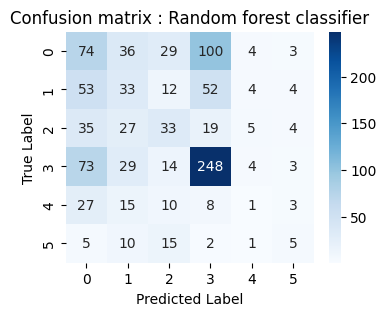

In [105]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test3, y_pred_rf))
plot_confusion_matrix(y_test3, y_pred_rf, title="Confusion matrix : Random forest classifier")

On constate qu'on a de meilleurs résultats que lors de la configuration précédente avec variables "Vert". On peut donc se dire que c'est plus facile de faire de la réaffectation dans cette configuration. On a aussi une meilleure répartition que dans le cas avant. On arrive à mieux généraliser que l'analyse discriminante.

#### XGBoost avec variables "Orange"

XGBoost est normalement le modèle le plus performant et optimisé ici. Il construit un ensemble d'arbres de décisions en corrigieant les erreurs à chaque itérations, ce qui permet d'avoir un modèle performant, rapide et efficace même sur des grand volumes de données.

In [106]:
"""
On entraine le modèle XGBoost
"""
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")
xgb.fit(X_train3, y_train3)

"""
On prédit avec les données de test
"""
y_pred_xgb = xgb.predict(X_test3)

Classification report :
               precision    recall  f1-score   support

           0       0.30      0.35      0.33       246
           1       0.29      0.22      0.25       158
           2       0.31      0.29      0.30       123
           3       0.59      0.68      0.63       371
           4       0.16      0.06      0.09        64
           5       0.26      0.16      0.20        38

    accuracy                           0.42      1000
   macro avg       0.32      0.29      0.30      1000
weighted avg       0.39      0.42      0.40      1000



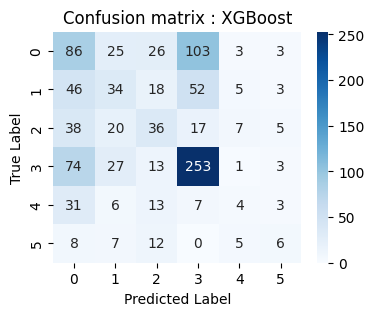

In [107]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test3, y_pred_xgb))
plot_confusion_matrix(y_test3, y_pred_xgb, title="Confusion matrix : XGBoost")

Le modèle XGBoost réussi à avoir un peu de meilleurs résultats et généralise mieux que le Random Forest Classifier. Vu que notre accuracy est améliorable en changeant les hyper paramètres, regardons les résultats des autres modèles avant de le faire.

#### Regression Logistique multinomiale avec variables "Orange"

La régression logistique multinomiale est une régression logistique à plusieurs classes. Elle modélise la probabilité d'appartenance à chaque classe via des fonctions logistiques en estimant les coefficients pour chaque variable.

In [108]:
"""
On entraine le modèle Logistic Regression Multinomial
"""
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train3, y_train3)

"""
On prédit avec les données de test
"""
y_pred_lr = lr.predict(X_test3)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.30      0.44      0.35       246
           1       0.29      0.06      0.10       158
           2       0.33      0.24      0.27       123
           3       0.60      0.79      0.68       371
           4       0.00      0.00      0.00        64
           5       0.48      0.26      0.34        38

    accuracy                           0.45      1000
   macro avg       0.33      0.30      0.29      1000
weighted avg       0.40      0.45      0.40      1000



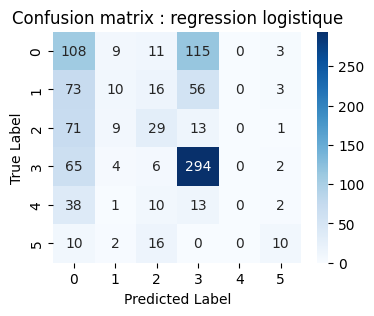

In [109]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test3, y_pred_lr))
plot_confusion_matrix(y_test3, y_pred_lr, title="Confusion matrix : regression logistique")

On a a peu près les mêmes résultats que l'analyse discriminante.


Après avoir vu les résultats des différents modèles, essayons de changer les paramètres de XGBoost pour essayer d'avoir de meilleurs résultats.

In [110]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='recall_macro', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train3, y_train3)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test3)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Meilleure accuracy : 0.32559018438648757


Classification report :
               precision    recall  f1-score   support

           0       0.31      0.44      0.36       246
           1       0.21      0.09      0.13       158
           2       0.32      0.30      0.31       123
           3       0.61      0.72      0.66       371
           4       1.00      0.02      0.03        64
           5       0.43      0.24      0.31        38

    accuracy                           0.44      1000
   macro avg       0.48      0.30      0.30      1000
weighted avg       0.45      0.44      0.41      1000



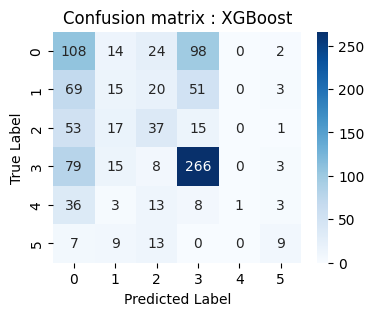

In [111]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test3, y_pred))
plot_confusion_matrix(y_test3, y_pred, title="Confusion matrix : XGBoost")

On constate que lorsqu'on essaye de prendre les meilleurs résultats sur le recall, notre accuracy est de 0.44. Notre modèle à de bons résultats mais n'arrive pas trop a généraliser sur les clusters 4 et 5. Ceci peut être dû au nombre de données qui n'est pas très grand, et nos clusters qui étaient de base moyen (silhouette score de 0.31 et ratio de 2.6). Essayons d'avoir de meilleurs résultats avec la meilleure accuracy.

In [112]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train3, y_train3)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test3)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Meilleure accuracy : 0.45499999999999996


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.29      0.52      0.37       246
           1       0.16      0.03      0.05       158
           2       0.33      0.24      0.28       123
           3       0.63      0.71      0.67       371
           4       0.00      0.00      0.00        64
           5       0.47      0.24      0.32        38

    accuracy                           0.43      1000
   macro avg       0.31      0.29      0.28      1000
weighted avg       0.39      0.43      0.39      1000



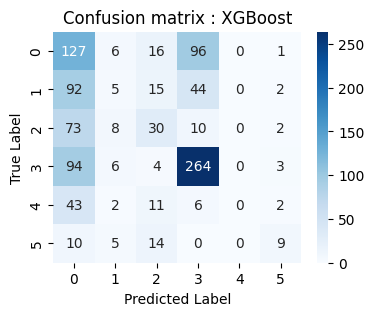

In [114]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test3, y_pred))
plot_confusion_matrix(y_test3, y_pred, title="Confusion matrix : XGBoost")

Notre meilleur accuracy est de 0.45.

Nous avons essayé en équilibrant le poids des classes, les résultats étaient encore pire.

On peut donc conclure qu'essayer de classifier les consommateurs dans des groupes clusteriser par leurs comportements en fonction de leurs opinions ne donne pas de bons résultats. La différence entre l'opinion et leur comportement (les actions qu'ils entreprennent réellement) sont difficile à corréler. Meme si nos résultats montrent que ce sera toujours mieux d'utiliser nos modèles que de distribuer les individus aléatoirements dans les groupes.

Mais on constate aussi que d'essayer de classifier les consommateurs dans des groupes clusteriser par leurs comportements en fonction de leurs opinions donne de meilleurs résultats (0.45) que de classifier les consommateurs dans des groupes clusteriser par leurs opinions en fonction de leurs comportements (0.42). 

#### Analyse Discriminante avec variables "RS"

Nous allons maintenant utiliser les variables qui caractérisent les données personelles des individus pour essayer de les classer dans des groupes divisé avec la métrique de leurs comportements/activités.

L'analyse discriminante est une méthode de classification supervisée qui va chercher des combinaisons linéaires de nos variables pour les séparer en groupes. Pour chaque nouvel individu, on va évaluer son score d'appartenance grâce aux combinaisons linéaires de chaque groupe et va lui assigner celui qui maximise ce score.

In [117]:
"""
On entraine le modèle Analyse Discriminante
"""
lda = LinearDiscriminantAnalysis()
lda.fit(X_train4, y_train4)

"""
On prédit avec les données de test
"""
y_pred = lda.predict(X_test4)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.32      0.31      0.31       246
           1       0.00      0.00      0.00       158
           2       0.00      0.00      0.00       123
           3       0.41      0.84      0.55       371
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        38

    accuracy                           0.39      1000
   macro avg       0.12      0.19      0.14      1000
weighted avg       0.23      0.39      0.28      1000



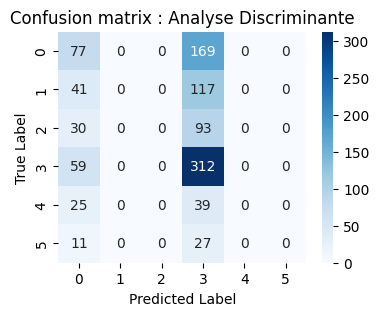

In [118]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test4, y_pred))
plot_confusion_matrix(y_test4, y_pred, title="Confusion matrix : Analyse Discriminante")

En utilisant les variables "RS", nous avons de moins bon résultats (-0.05 en accuracy). Notre modèle ne généralise absolument pas et préfère prédire juste dans le cluster 0 et 3.

#### Random Forest avec variables "RS"

Random Forest Classifier va construire un grand nombre d'arbes de décision, puis les prédictions de tous ces arbres seront ensuite agrégées pour améliorer la robustesse et la précision.

In [119]:
"""
On entraine le modèle Random Forest Classifier
"""
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train4, y_train4)

"""
On prédit avec les données de test
"""
y_pred_rf = rf.predict(X_test4)

Classification report :
               precision    recall  f1-score   support

           0       0.27      0.32      0.29       246
           1       0.16      0.13      0.14       158
           2       0.10      0.07      0.08       123
           3       0.43      0.50      0.46       371
           4       0.14      0.08      0.10        64
           5       0.11      0.08      0.09        38

    accuracy                           0.30      1000
   macro avg       0.20      0.20      0.20      1000
weighted avg       0.28      0.30      0.29      1000



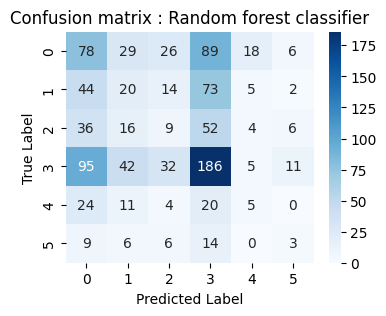

In [120]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test4, y_pred_rf))
plot_confusion_matrix(y_test4, y_pred_rf, title="Confusion matrix : Random forest classifier")

Ici, notre modèle random forest arrive un peu plus à généraliser, mais notre accuracy est moins bonne (-0.10).

#### XGBoost avec variables "RS"

XGBoost est normalement le modèle le plus performant et optimisé ici. Il construit un ensemble d'arbres de décisions en corrigieant les erreurs à chaque itérations, ce qui permet d'avoir un modèle performant, rapide et efficace même sur des grand volumes de données.

In [121]:
"""
On entraine le modèle XGBoost
"""
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")
xgb.fit(X_train4, y_train4)

"""
On prédit avec les données de test
"""
y_pred_xgb = xgb.predict(X_test4)

Classification report :
               precision    recall  f1-score   support

           0       0.28      0.38      0.32       246
           1       0.21      0.13      0.16       158
           2       0.15      0.08      0.11       123
           3       0.42      0.53      0.47       371
           4       0.17      0.06      0.09        64
           5       0.12      0.05      0.07        38

    accuracy                           0.33      1000
   macro avg       0.23      0.20      0.20      1000
weighted avg       0.29      0.33      0.30      1000



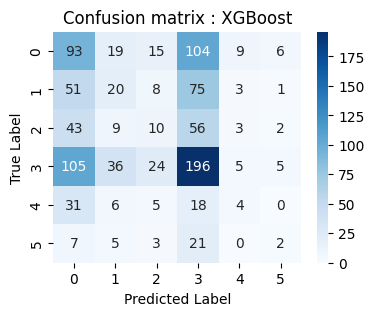

In [122]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test4, y_pred_xgb))
plot_confusion_matrix(y_test4, y_pred_xgb, title="Confusion matrix : XGBoost")

Meme chose que random forest.

#### Regression Logistique multinomiale avec variables "RS"

La régression logistique multinomiale est une régression logistique à plusieurs classes. Elle modélise la probabilité d'appartenance à chaque classe via des fonctions logistiques en estimant les coefficients pour chaque variable.

In [123]:
"""
On entraine le modèle Logistic Regression Multinomial
"""
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train4, y_train4)

"""
On prédit avec les données de test
"""
y_pred_lr = lr.predict(X_test4)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.30      0.32      0.31       246
           1       0.00      0.00      0.00       158
           2       0.00      0.00      0.00       123
           3       0.41      0.82      0.55       371
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        38

    accuracy                           0.38      1000
   macro avg       0.12      0.19      0.14      1000
weighted avg       0.23      0.38      0.28      1000



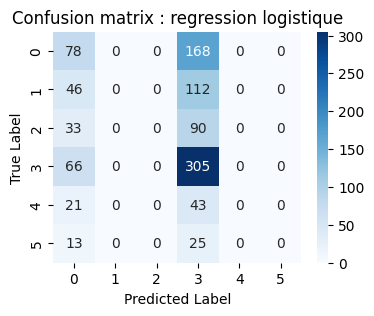

In [124]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test4, y_pred_lr))
plot_confusion_matrix(y_test4, y_pred_lr, title="Confusion matrix : regression logistique")

Pareil que Analyse Discriminative

Après avoir vu les résultats des différents modèles, essayons de changer les paramètres de XGBoost pour essayer d'avoir de meilleurs résultats.

In [125]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='recall_macro', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train4, y_train4)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test4)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
Meilleure accuracy : 0.21021413958771812


Classification report :
               precision    recall  f1-score   support

           0       0.27      0.34      0.30       246
           1       0.20      0.13      0.16       158
           2       0.20      0.11      0.14       123
           3       0.41      0.52      0.46       371
           4       0.14      0.08      0.10        64
           5       0.09      0.05      0.07        38

    accuracy                           0.32      1000
   macro avg       0.22      0.20      0.20      1000
weighted avg       0.29      0.32      0.30      1000



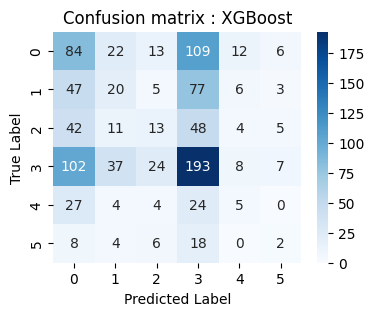

In [126]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test4, y_pred))
plot_confusion_matrix(y_test4, y_pred, title="Confusion matrix : XGBoost")

On constate que lorsqu'on essaye de prendre les meilleurs résultats sur le recall, notre accuracy n'est que de 0.32. Nos modèles n'arrivent pas trop à généraliser, ce qui doit etre dû au nombre de données qui n'est pas très grande, et nos clusters qui étaient de base moyen (0.31 de silhouette score et un ratio de 2.6) Essayons de voir les résultats avec la meilleure accuracy.

In [127]:
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

"""
On fait la grille de paramètres
"""
param_grid = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train4, y_train4)

print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure accuracy :", grid_search.best_score_)

best_model = grid_search.best_estimator_

"""
On prédit
"""
y_pred = best_model.predict(X_test4)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Meilleurs paramètres : {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Meilleure accuracy : 0.382


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification report :
               precision    recall  f1-score   support

           0       0.34      0.29      0.31       246
           1       0.00      0.00      0.00       158
           2       0.00      0.00      0.00       123
           3       0.40      0.85      0.54       371
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00        38

    accuracy                           0.39      1000
   macro avg       0.12      0.19      0.14      1000
weighted avg       0.23      0.39      0.28      1000



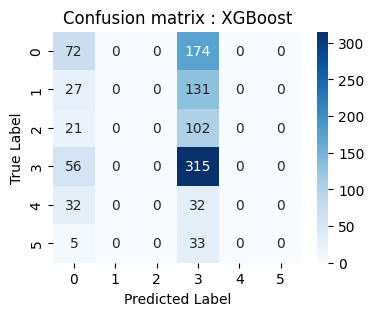

In [128]:
"""
On fait les évaluations
"""
print("Classification report :\n", classification_report(y_test4, y_pred))
plot_confusion_matrix(y_test4, y_pred, title="Confusion matrix : XGBoost")

Notre meilleure accuracy est de 0.39

Nous avons aussi essayé en équilibrant le poids des classes, les résultats étaient encore pire.

On peut donc conclure qu'essayer de classifier les consommateurs dans des groupes clusteriser par leurs comportements en fonction de leurs informations personnelles donne de pires résultats que lorsqu'on utilisait leurs données d'opinion. La différence entre les comportements et leurs informations personnelles sont presque impossible à corréler dans cette étude. Meme si nos résultats montrent que ce sera toujours mieux d'utiliser nos modèles que de distribuer les individus aléatoirements dans les groupes.

Mais on constate aussi que d'essayer de classifier les consommateurs dans des groupes clusteriser par leurs comportements en fonction de leurs opinions donne de meilleurs résultats (0.39) que de classifier les consommateurs dans des groupes clusteriser par leurs opinions en fonction de leurs comportements (0.29).

Globalement dans les 2 cas "Orange" et "RS" les résultats sont meilleurs. Il faudra donc prioriser cette étude pour proposer des offres en utilisant la méthode de réaffectation des individus.

Pour conclure pour la partie "Segmentation des variables en Vert", on constate que les variables "Orange" et "RS" ne sont pas forcément corrélés avec les clusters créer avec les variables "Vert". 
Si l'on veut utiliser cette méthode en se basant uniquement sur des variables illustratives (disponible sur le ficher annexe ou client), on pourra plus ou moins attribuer un nouvel individu au cluster auquel il a le plus de probabilité d'appartenir. Il faudra prioriser une segmentation variable en "Vert", là où nous avons eu de meilleurs résultats.